In [9]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import pickle
df = pd.read_csv('data/haystacks_ga_clean_new_format.csv')

In [10]:
## Mask for turning crime grades into integers. Will eventually put this in data preprocessing.
mask = {'F': 0,
       'D-': 1,
       'D': 2,
       'D+': 3,
       'C-': 4,
       'C': 5,
       'C+': 6,
       'B-': 7,
       'B': 8,
       'B+': 9,
       'A-': 10,
       'A': 11}
df['overall_crime_grade'] = df['overall_crime_grade'].apply(lambda row: mask[row])
df['property_crime_grade'] = df['property_crime_grade'].apply(lambda row: mask[row])
df = df.drop(['details', 
              'special_features',   
              'state', 
              'county',  
              'rent',
              'caprate',
              'address',
              'longitude',
              'latitude',
              'address',
              'city'], axis=1)

In [11]:
df.head()

,zipcode,listing_status,square_footage,overall_crime_grade,ES_rating,lot_size,baths_half,MS_rating,HS_rating,listing_special_features,beds,price,baths_full,year_built,property_crime_grade,transaction_type
0,31643,1,1460.0,1,1.000000,0.0,0.0,2.0,2.5,0,3.0,99000,1.0,1910.0,1,1
1,31643,1,1460.0,1,1.000000,0.0,0.0,2.0,2.5,0,3.0,99000,1.0,1910.0,1,1
2,31548,1,1618.0,7,7.333333,0.0,0.0,6.0,8.0,0,3.0,200000,2.0,1986.0,6,1
3,31548,1,2103.0,7,7.333333,0.0,0.0,6.0,8.0,2,4.0,339900,2.0,2020.0,6,1
4,31548,1,2954.0,7,7.333333,0.0,0.0,6.0,8.0,0,4.0,679900,3.0,2019.0,6,1


In [14]:
## creates dataframe for each zipcode
zip_dfs=[]
for zipcode in sorted(set(df.zipcode.values)):
    zip_dfs.append((df.loc[df.zipcode==zipcode,:], zipcode)
                  )
    
    
    
## list for models
models = []

## list for shap values and explainers
shaps = []
ziplist = []


for zdf in zip_dfs:
    
    X = zdf[0].drop(['price',
                     'zipcode'],
                    axis=1)

    y = zdf[0][['price']]
    
    if len(zdf[0]) == 1:
        X_train = X
        y_train = y
        
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
    models.append((RandomForestRegressor().fit(X_train, np.ravel(y_train)), zdf[1]))
    
    explainer = shap.Explainer(models[-1][0], X)
    shap_values = explainer(X)
    shaps.append([explainer, shap_values, zdf[1]])

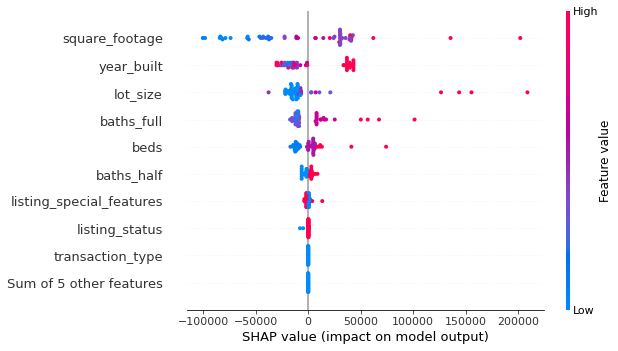

In [15]:
shap.plots.beeswarm(shaps[5][1])

In [ ]:
## series for each indexed by zipcode

mod_ser = pd.Series([], dtype='O')
for i in range(len(models)):
    mod_ser[models[i][1]] = models[i][0]
mod_ser = mod_ser.to_frame().reset_index()
mod_ser.columns = ['zipcode','model']
    
sv_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    sv_ser[shaps[i][2]] = shaps[i][1]
sv_ser = sv_ser.to_frame().reset_index()
sv_ser.columns = ['zipcode', 'shap_values']

exp_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    exp_ser[shaps[i][2]] = shaps[i][0]
exp_ser = exp_ser.to_frame().reset_index()
exp_ser.columns = ['zipcode','explainer']

MS_df = mod_ser.merge(sv_ser, on='zipcode')
MS_df = MS_df.merge(exp_ser, on='zipcode')
MS_df.index = MS_df.zipcode

## The below can be taken out if desired.
MS_df = MS_df.drop(['zipcode'], axis=1)